# Face detection on masked and non-masked images

In this notebook we apply the RetinaFace face detector (https://github.com/hukkelas/DSFD-Pytorch-Inference) to our collected images.  
The resulting cropped faces will be used to evaluate the complete pipeline (i.e. detector and mask/no_mask classifier) in evaluate_pipeline.ipynb.  
We also plot some results of the detector to get an idea of its performance on both unmasked and masked faces.

### Imports

In [1]:
from pathlib import Path

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import random
import os

import face_detection

### Setup 

In [2]:
root_dir = os.path.dirname(os.path.abspath(os.curdir))
data_dir = Path(root_dir) / 'data'
raw_images_dir = data_dir / 'raw_images'

# this file contain ground truth annotations, detector bboxes will be compared to this
ground_truth_annotations_fn = data_dir / 'test_validation_metadata.csv'

# this is an output file, detector bboxes will be written here
# these are needed to evaluate the complete pipeline, see evaluate_pipeline.ipynb
detector_bbox_annotations_fn = data_dir / 'detector_annotations.csv'

# these are the cropped faces corresponding to bboxes produced by the detector
# these will serve as input to the mask/no_mask classifier in the evaluation of the pipeline 
detector_crop_output = data_dir / 'overall_model_evaluation' / 'detector_crops'
detector_crop_output.mkdir(exist_ok=True, parents=True)

# this will be used to store the results of the detector, and to plot some of these at the end of this notebook
detector_result_dir = data_dir / 'overall_model_evaluation' / 'detector_results'
detector_result_dir.mkdir(exist_ok=True, parents=True)

### Load the RetinaFace model

In [3]:
detector = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.5, nms_iou_threshold=.3)

### Detect faces and store results

In [4]:
detector_bbox = pd.DataFrame(columns=['img','bbox_id','x','y','w','h','crop_fn'])
real_raw_img = list(sorted(raw_images_dir.glob('*.jpg')))

for idx, fn in enumerate(real_raw_img):

    img = cv2.imread(str(fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    detections = detector.detect(img)
 
    for row_index in range(detections.shape[0]):
        ann = detections[row_index]
        x1 = int(ann[0])
        y1 = int(ann[1])
        x2 = int(ann[2])
        y2 = int(ann[3])
        
        cropped_face = img[y1:y2, x1:x2]
        
        if cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
            print(f"Detector extracted a face with 0 rows or columns, skipping this one for {fn}")
            continue

        output_fn = detector_crop_output / (fn.stem + '_' + str(row_index) + '.jpg')
        cv2.imwrite(str(output_fn), cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))     
        
        detector_bbox.loc[len(detector_bbox)] = [fn.name,row_index,x1,y1,x2-x1,y2-y1, str(output_fn)]
    
detector_bbox.to_csv(detector_bbox_annotations_fn, index=False)

Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/101.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/12.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/130.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/133.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/149.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/179.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_fresh/face-mask-detection/data/raw_images/245.jpg


## Compare detected faces to ground truth annotations

#### Helper function to comput IoU

In [5]:
def bb_intersection_over_union(boxA, boxB):
    '''
    from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

#### Write images to file with ground truth and detector annotations

In [6]:
ground_truth = pd.read_csv(ground_truth_annotations_fn)
ground_truth['img_name'] = ground_truth.raw_img_dir.apply(lambda x: Path(x).name)

fn_to_gt_boxes = dict()
fn_to_detector_boxes = dict()

for idx, img_fn in enumerate(real_raw_img):

    img = cv2.imread(str(img_fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img/255)
    
    ground_truth_fn = ground_truth[ground_truth.img_name == img_fn.name]
    gt_boxes = []
    for row_idx in range(ground_truth_fn.shape[0]):
        ground_truth_annotation = ground_truth_fn.iloc[row_idx]
        x = ground_truth_annotation.x.item()
        y = ground_truth_annotation.y.item()
        w = ground_truth_annotation.w.item()
        h = ground_truth_annotation.h.item()
        gt_boxes.append((x,y,x+w,y+h))
        rect = plt.Rectangle((x,y),w,h,linewidth=3,edgecolor='green',facecolor='none')
        plt.gca().add_patch(rect)
    fn_to_gt_boxes[img_fn] = gt_boxes
    
    bbox_fn = detector_bbox[detector_bbox.img == img_fn.name]
    pred_boxes = []
    for row_idx in range(bbox_fn.shape[0]):
        pred_annotation = bbox_fn.iloc[row_idx]
        x = pred_annotation.x
        y = pred_annotation.y
        w = pred_annotation.w
        h = pred_annotation.h
        pred_boxes.append((x,y,x+w,y+h))
        rect = plt.Rectangle((x,y),w,h,linewidth=3,edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
    fn_to_detector_boxes[img_fn] = pred_boxes
    
    plt.axis('off')
    plt.savefig(detector_result_dir / img_fn.name, bbox_inches='tight', pad_inches=0)
    plt.close()

#### Compute performance statistics for the detector

In [7]:
tp = 0
fp = 0
fn = 0

correct = []
mistakes = []
    
for idx, img_fn in enumerate(real_raw_img):
    pred_boxes = fn_to_detector_boxes[img_fn]
    gt_boxes = fn_to_gt_boxes[img_fn]
    
    # we have to keep track of previous fn and fp to see if there was a mistake
    # in this particular image
    fn_prev = fn
    fp_prev = fp
    
    # first we check for each ground truth bounding box whether it was detected
    for gt_box in gt_boxes:
        times_found = 0
        for pred_box in pred_boxes: 
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou >= 0.5:
                times_found += 1
        
        if times_found > 0:
            # the face was detected at least once, so it is a true positive
            tp += 1
        
            # if it is detected more than once, we add the duplicate detections to the false positives
            n_duplicates = times_found - 1
            if n_duplicates > 0:
                fp += n_duplicates
        
        if times_found == 0:
            fn += 1
        
    # we also have to check for detected bounding boxes that do not overlap with any ground truth bounding box,
    # as these are counted as false negatives
    for pred_box in pred_boxes:
        found = False
        for gt_box in gt_boxes:
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou > 0.5:
                found = True
                break
        if not found:
            fp += 1
            
    if fn_prev != fn or fp_prev != fp:
        mistakes.append(detector_result_dir / img_fn.name)
    else:
        correct.append(detector_result_dir / img_fn.name)

In [8]:
print(f"Number of true positives: {tp}")
print(f"Number of false positives: {fp}")
print(f"Number of false negatives: {fn}")

Number of true positives: 467
Number of false positives: 39
Number of false negatives: 56


#### Plot some good and bad cases

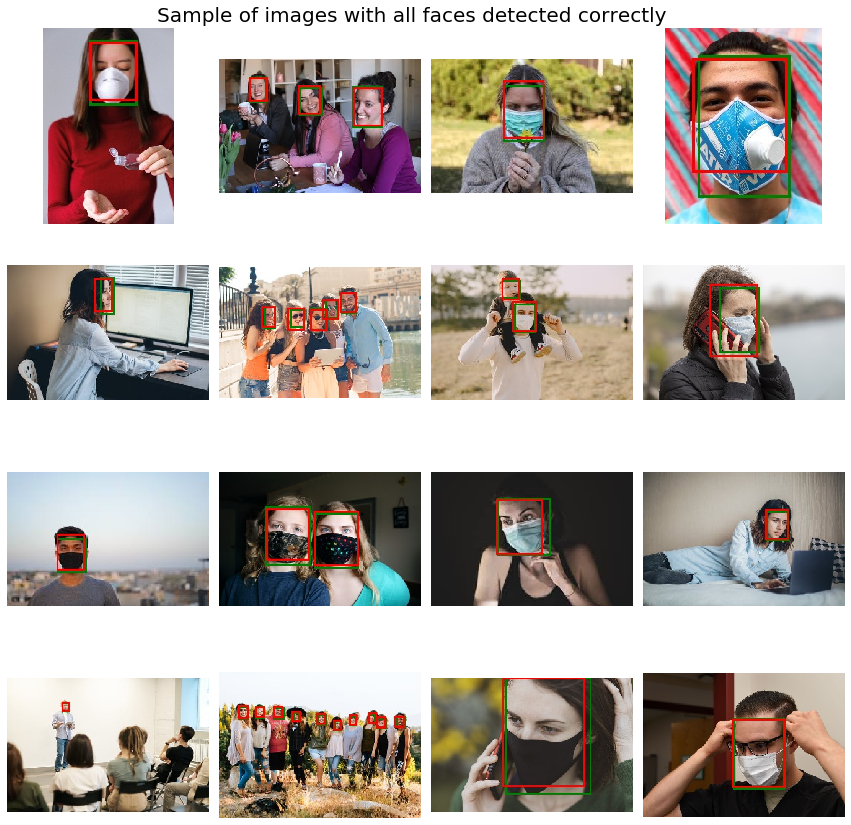

In [9]:
n_to_plot = 16
to_plot = random.sample(correct,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with all faces detected correctly', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

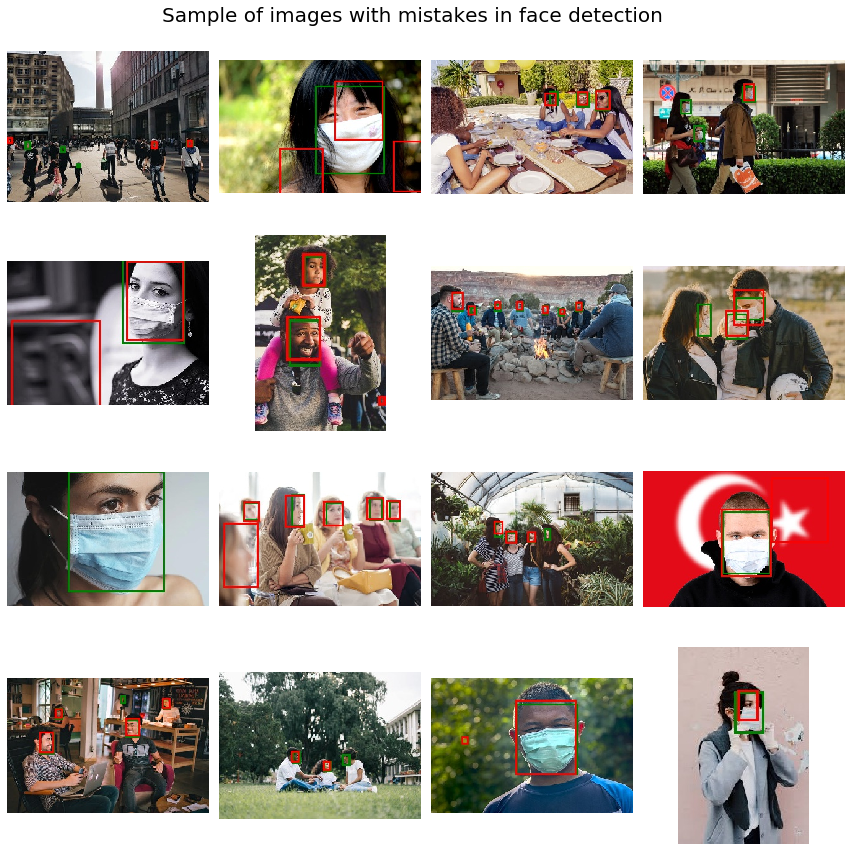

In [10]:
n_to_plot = 16
to_plot = random.sample(mistakes,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with mistakes in face detection', size=20, y=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()